# Dependencies

In [1]:
library(ggplot2)
library(zoo)
library(tseries)
library(forecast)


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



ERROR: Error in library(forecast): there is no package called 'forecast'


# Load Data

Source: https://gml.noaa.gov/ccgg/trends/data.html

Below we load the daily average from 1974 to 2024

In [2]:
url <- "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_daily_mlo.txt"

data <- read.delim(url,
    comment.char = "#",
    header = FALSE,
    sep = "",
    col.names = c("YY", "MM", "DD", "Decimal", "CO2_PPM")
)

str(data)

'data.frame':	15331 obs. of  5 variables:
 $ YY     : int  1974 1974 1974 1974 1974 1974 1974 1974 1974 1974 ...
 $ MM     : int  5 5 5 5 5 5 5 5 5 5 ...
 $ DD     : int  17 18 19 20 21 22 23 26 27 28 ...
 $ Decimal: num  1974 1974 1974 1974 1974 ...
 $ CO2_PPM: num  333 333 333 334 334 ...


# Clean Data

Check for na-values.

> Due to the eruption of the Mauna Loa Volcano, measurements from Mauna Loa Observatory were suspended as of Nov. 29, 2022 and resumed in July 2023. Observations starting from December 2022 to July 4, 2023 are from a site at the Maunakea Observatories, approximately 21 miles north of the Mauna Loa Observatory.

What do we do about this? Missing data for the days 2022-11-29 to 2022-11-7.

There also seems to be a couple of periods where we have a couple of missing measurements, e.g. 2023-7-11 to 2023-7-12.

These missing values are probably negligble since we have roughly 15 K datapoints

In [3]:
# Create a Date column in the data frame
data$Date <- as.Date(with(data, paste(YY, MM, DD, sep="-")), format="%Y-%m-%d")

# Create a sequence of dates from the start to the end of your dataset
start_date <- min(data$Date)
end_date <- max(data$Date)
all_dates <- seq(from = start_date, to = end_date, by = "day")

# Identify the missing dates
missing_dates <- setdiff(all_dates, data$Date)

# Num. of na-values
num_of_na <- which(is.na(data))

# Print the missing dates
print("No. of dates in dataset:")
print(nrow(data))
print("No. of dates from 1974-5-17 to 2024-4-18 should be:")
print(length(all_dates))
print("No. of missing dates:")
print(length(missing_dates))
print("No. of na-values:")
print(num_of_na)



[1] "No. of dates in dataset:"
[1] 15331
[1] "No. of dates from 1974-5-17 to 2024-4-18 should be:"
[1] 18239
[1] "No. of missing dates:"
[1] 2908
[1] "No. of na-values:"
integer(0)


# Initial Plot of the Time Series

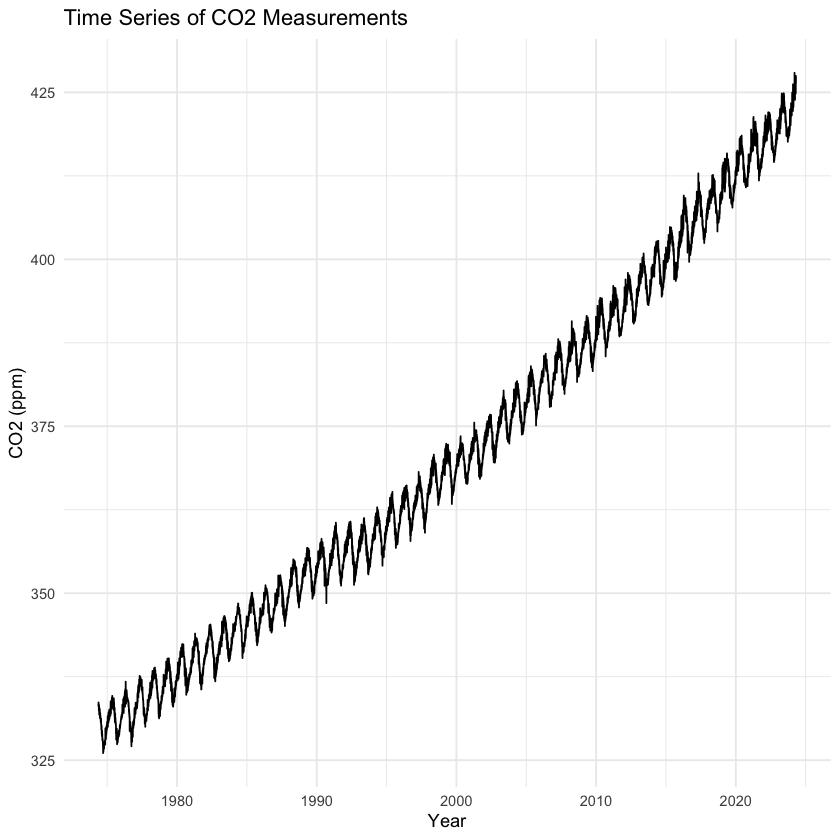

In [4]:
# Simple time series plot with ggplot2
ggplot(data, aes(x = Date, y = CO2_PPM)) +
  geom_line() +
  labs(title = "Time Series of CO2 Measurements",
       x = "Year",
       y = "CO2 (ppm)") +
  theme_minimal()

# Interpolate missing dates

In [5]:
full_data <- data.frame(Date = all_dates)
full_data <- merge(full_data, data, by = "Date", all = TRUE)
full_data$CO2_PPM <- zoo(full_data$CO2_PPM)
full_data$CO2_interp <- na.approx(full_data$CO2_PPM, na.rm = FALSE)
head(full_data)


,Date,YY,MM,DD,Decimal,CO2_PPM,CO2_interp
,<date>,<int>,<int>,<int>,<dbl>,<zoo>,<zoo>
1,1974-05-17,1974,5,17,1974.374,333.38,333.38
2,1974-05-18,1974,5,18,1974.377,333.11,333.11
3,1974-05-19,1974,5,19,1974.380,333.46,333.46
4,1974-05-20,1974,5,20,1974.382,333.64,333.64
5,1974-05-21,1974,5,21,1974.385,333.50,333.50
6,1974-05-22,1974,5,22,1974.388,333.21,333.21


# Create TS object

In [6]:
ts_data <- ts(full_data$CO2_interp, start = c(1974, 5, 17), frequency = 365)
summary(ts_data)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  326.1   348.5   368.0   371.1   392.8   427.9 

# Decompose

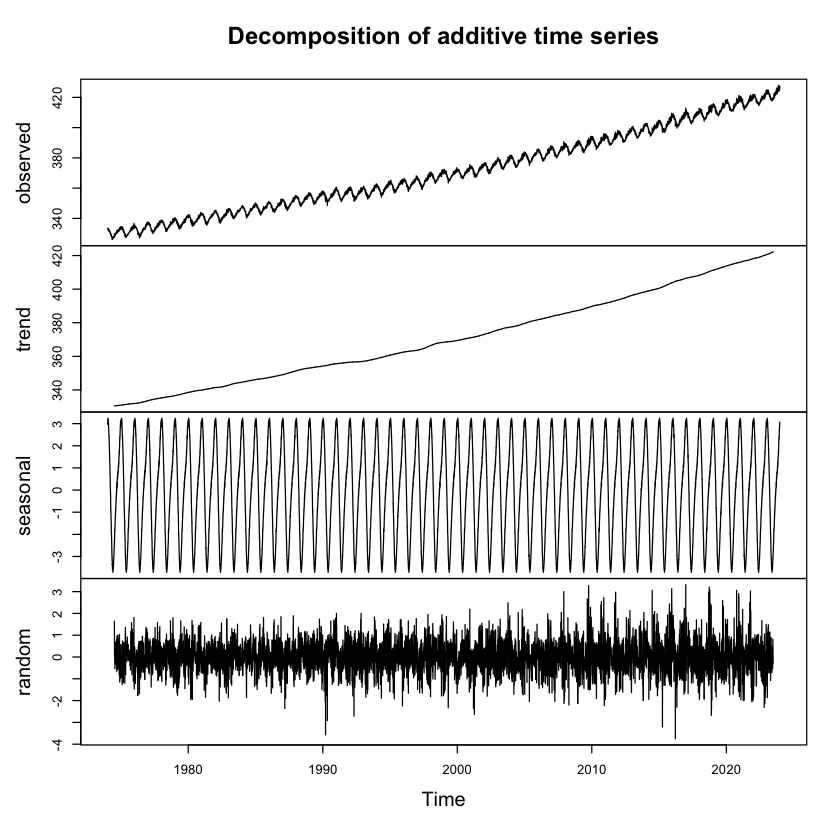

In [7]:
decomp <- decompose(ts_data)
plot(decomp)

# Fit trig and line to remove trend and seasonality


Call:
lm(formula = CO2_interp ~ trend1 + trend2 + sin1 + cos1 + sin2 + 
    cos2, data = full_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0729 -0.7020 -0.0761  0.6471  4.1820 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  3.309e+02  2.153e-02 15371.53   <2e-16 ***
trend1       3.131e-03  5.452e-06   574.34   <2e-16 ***
trend2       1.047e-07  2.894e-10   361.69   <2e-16 ***
sin1        -1.266e+00  1.014e-02  -124.84   <2e-16 ***
cos1         2.681e+00  1.015e-02   264.01   <2e-16 ***
sin2         6.987e-01  1.014e-02    68.88   <2e-16 ***
cos2         4.718e-01  1.015e-02    46.47   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.969 on 18232 degrees of freedom
Multiple R-squared:  0.9987,	Adjusted R-squared:  0.9987 
F-statistic: 2.317e+06 on 6 and 18232 DF,  p-value: < 2.2e-16


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): object 'poch' not found


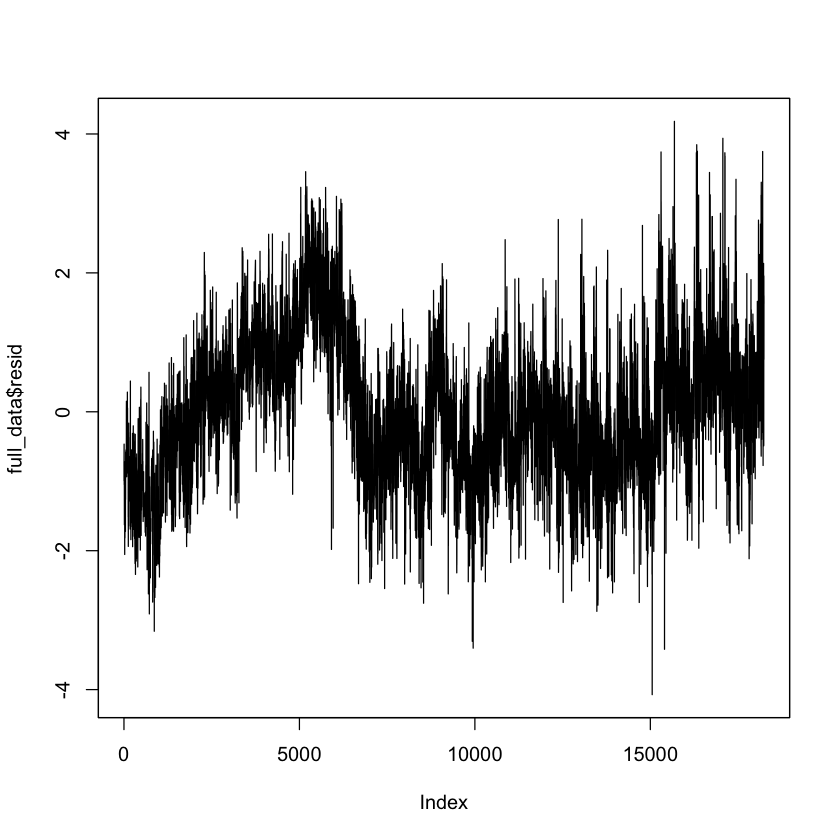

In [17]:
time_index <- 1:nrow(full_data)
full_data$trend1 <- time_index
full_data$trend2 <- time_index**2
full_data$sin1 <- sin(2 * pi * time_index / 365.25)
full_data$cos1 <- cos(2 * pi * time_index / 365.25)
full_data$sin2 <- sin(4 * pi * time_index / 365.25)
full_data$cos2 <- cos(4 * pi * time_index / 365.25)
model <- lm(CO2_interp ~ trend1 + trend2 + sin1 + cos1 + sin2 + cos2, data = full_data)
summary(model)
full_data$fitted <- predict(model)
full_data$resid <- full_data$CO2_interp - full_data$fitted

# ADF test

In [9]:
adf_res <- adf.test(full_data$resid, alternative = "stationary")
print(adf_res)

Warning message in adf.test(full_data$resid, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  full_data$resid
Dickey-Fuller = -7.0264, Lag order = 26, p-value = 0.01
alternative hypothesis: stationary



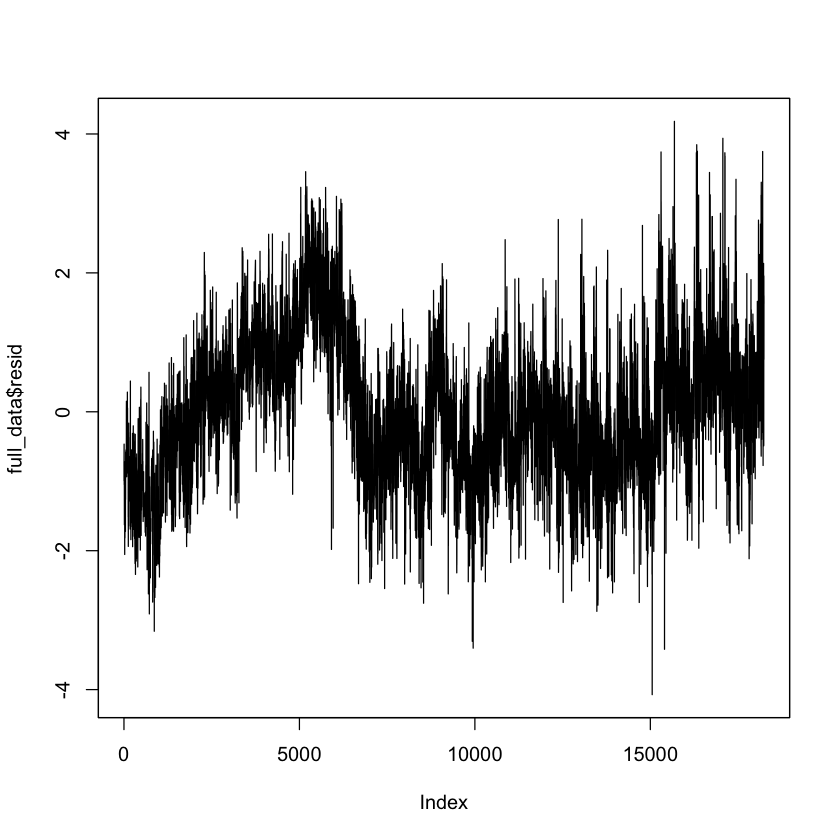

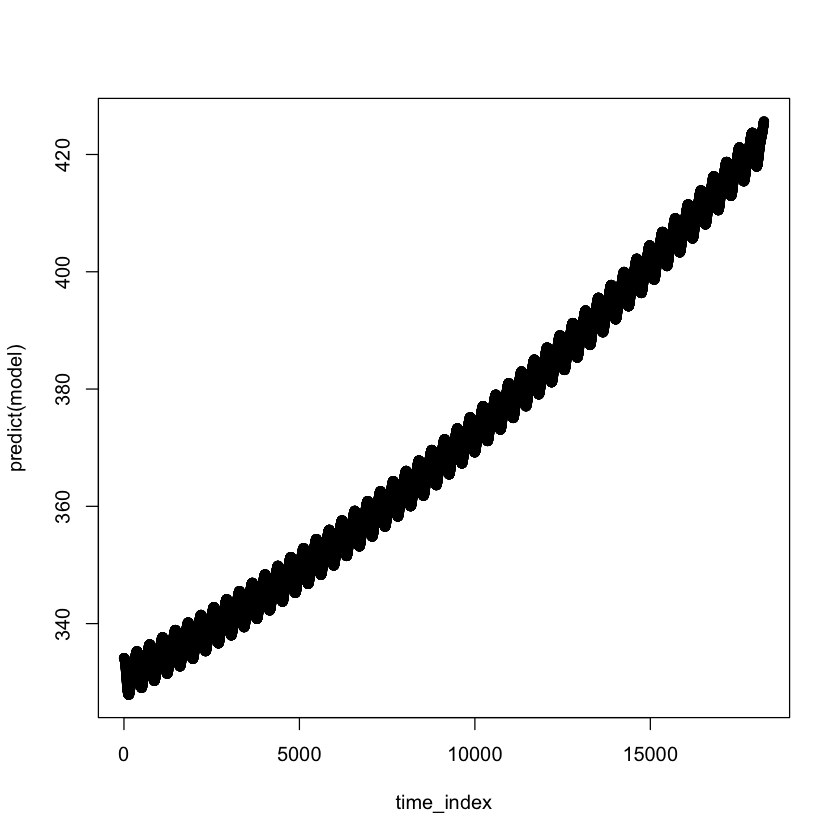

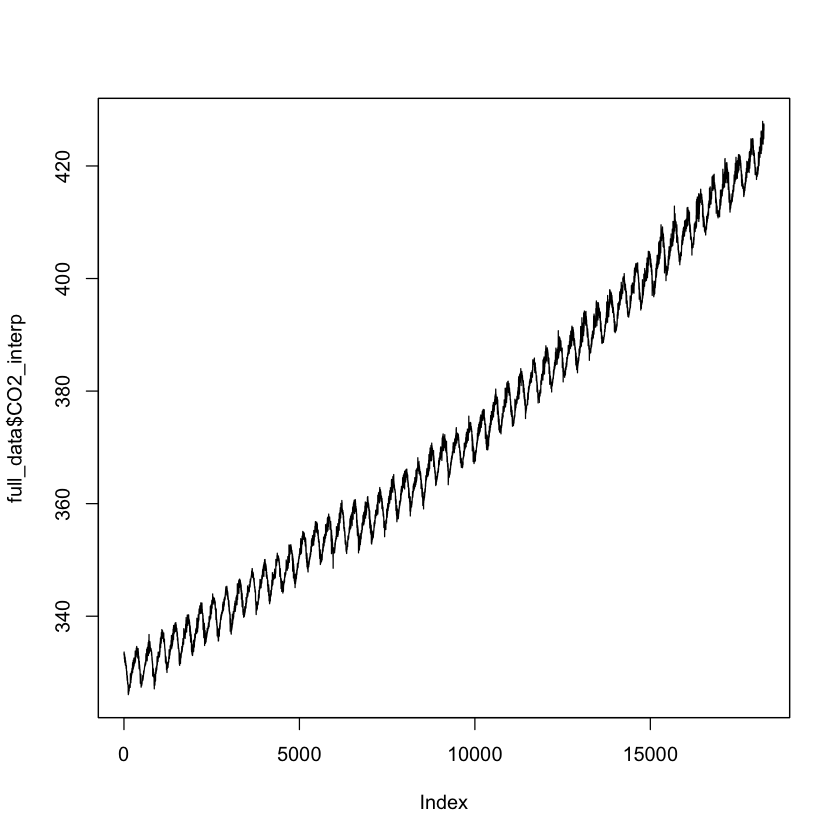

In [31]:
plot(full_data$resid)
plot(time_index, predict(model))
plot(full_data$CO2_interp)

In [33]:
ts_data %>% ggtsdisplay()

ERROR: Error in ts_data %>% ggtsdisplay(): could not find function "%>%"


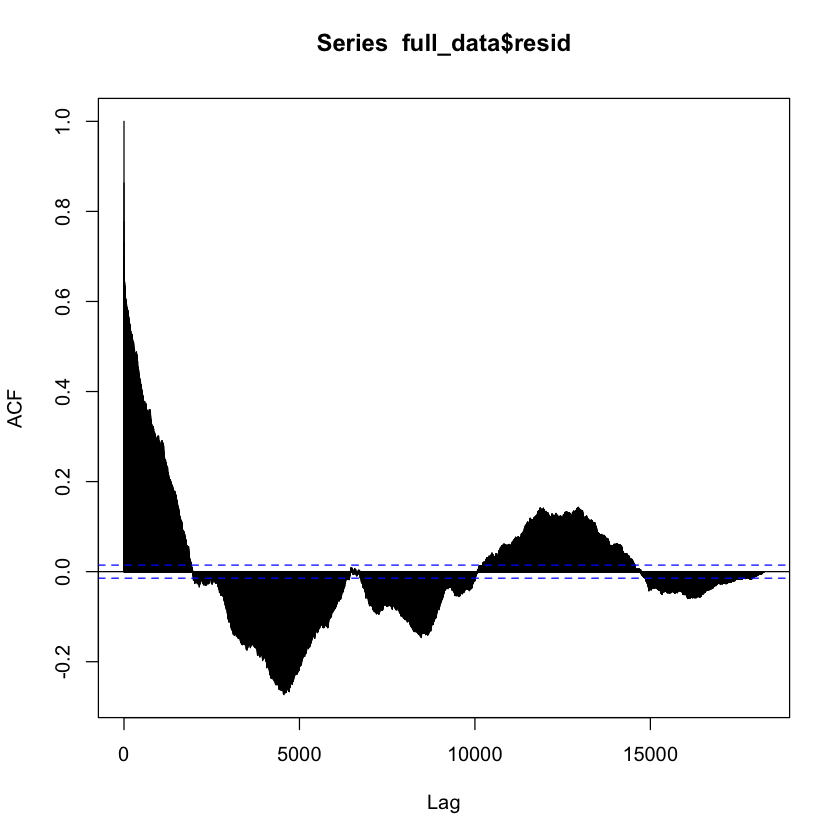

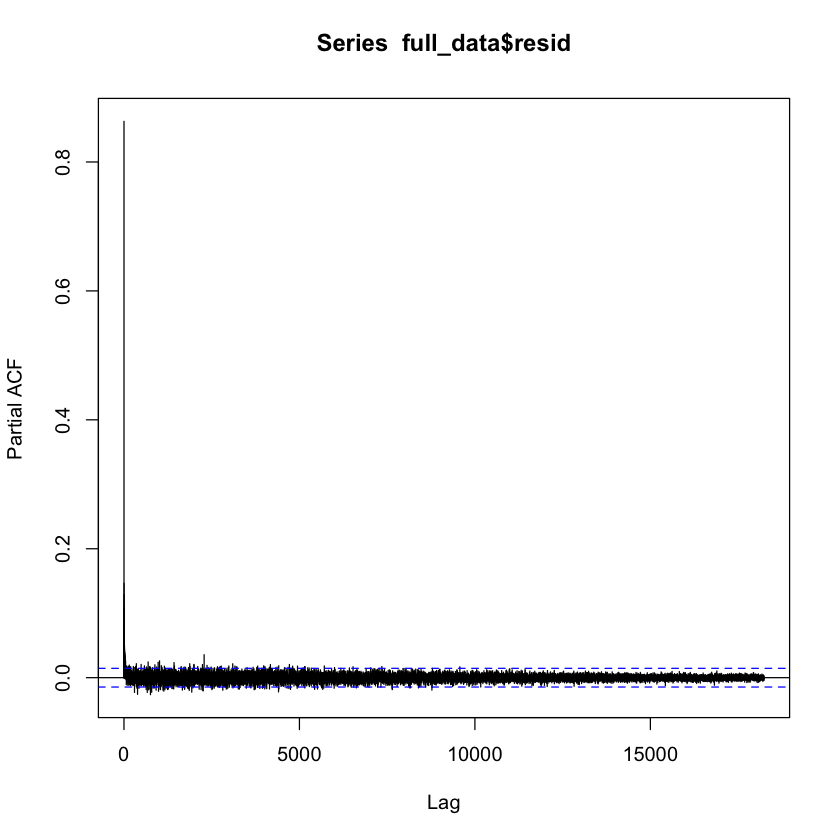

In [16]:
acf(full_data$resid, lag.max = 20000)
pacf(full_data$resid, lag.max = 20000)

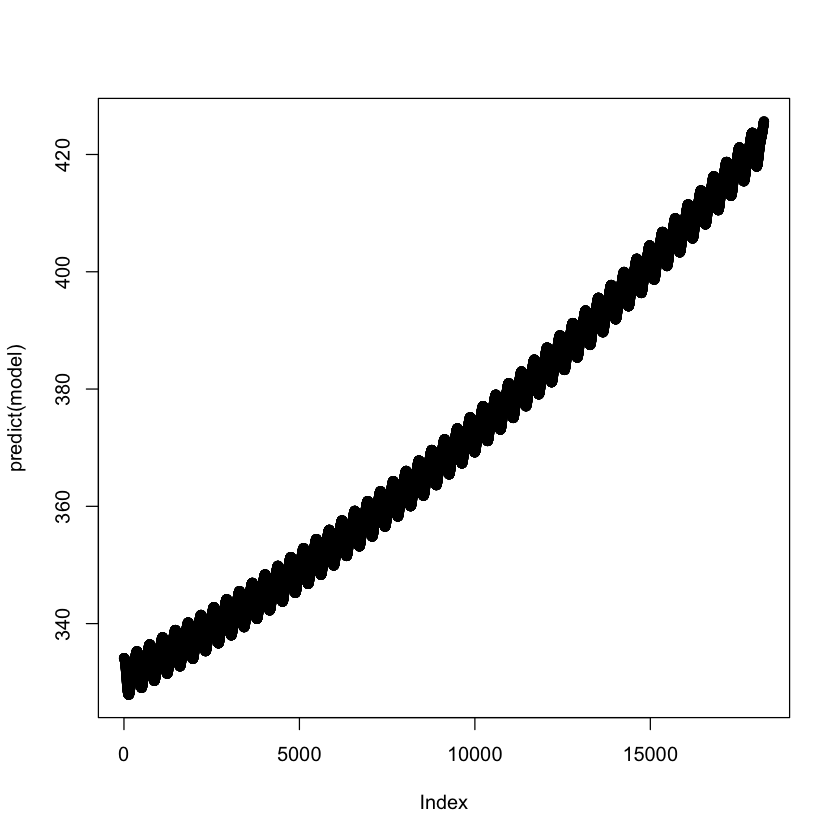

In [38]:
plot(predict(model))

In [36]:
print(full_data$CO2_interp)

       1        2        3        4        5        6        7        8 
333.3800 333.1100 333.4600 333.6400 333.5000 333.2100 333.0500 333.1400 
       9       10       11       12       13       14       15       16 
333.2300 333.3200 332.7900 332.4300 332.6000 333.3000 333.2500 333.2075 
      17       18       19       20       21       22       23       24 
333.1650 333.1225 333.0800 332.7500 331.8300 332.0900 332.0000 332.3600 
      25       26       27       28       29       30       31       32 
332.2500 332.2800 332.0300 331.8500 332.6300 332.0200 332.1000 332.1800 
      33       34       35       36       37       38       39       40 
332.7400 332.3300 332.3500 332.5300 332.3500 332.2500 331.4400 332.0800 
      41       42       43       44       45       46       47       48 
331.6800 331.2800 331.6100 331.7300 331.8500 331.6450 331.4400 332.0600 
      49       50       51       52       53       54       55       56 
331.6500 331.5800 331.5300 331.5500 331.5700 331.65